In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
class StepFunction:
    def __init__(self, x, y):
        """
        Initialize with breakpoints `x` and values `y`.
        `x` should have length k+1 and `y` should have length k.
        """
        if len(y) != len(x) - 1:
            raise ValueError("Length of y must be one less than length of x")
        self.x = x
        self.y = y

    def predict(self, z):
        # Predict step function value at z (scalar or array).
        z = np.asarray(z)
        result = np.zeros_like(z, dtype=float)
        for i in range(len(self.y)):
            result[(z >= self.x[i]) & (z < self.x[i + 1])] = self.y[i]
        return result

In [3]:
def Bin_smoothing(k, Train, Test, reg_func, test_size=0.2, random_state=None, plot=True):
    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(Train, Test, test_size=test_size, random_state=42)
    
    # Bin edges with dynamic allocation
    bin_width = (max(X_train) - min(X_train)) / k
    bins = np.linspace(min(X_train), max(X_train), k+1)
    bin_means = []  # or we can use np.zeros(k) to preallocate

    for i in range(k):
        # Get the indices of the training data that fall into the current bin
        indices = np.where((X_train >= bins[i]) & (X_train < bins[i+1]))[0]
        if len(indices) > 0:
            # Calculate the mean of Y values in this bin
            bin_mean = np.mean(y_train[indices])
        else:
            # If no data points in this bin, use NaN or some other value
            bin_mean = np.nan
        bin_means.append(bin_mean)

    # Handle NaN values in bin_means using forward and backward filling
    nan_indices = np.where(np.isnan(bin_means))[0]
    for idx in nan_indices:
        # Find the nearest non-NaN value
        left_val = bin_means[idx-1] if idx > 0 and not np.isnan(bin_means[idx-1]) else np.nan
        right_val = bin_means[idx+1] if idx < len(bin_means)-1 and not np.isnan(bin_means[idx+1]) else np.nan
        
        if not np.isnan(left_val) and not np.isnan(right_val):
            bin_means[idx] = (left_val + right_val) / 2
        elif not np.isnan(left_val):
            bin_means[idx] = left_val
        elif not np.isnan(right_val):
            bin_means[idx] = right_val

    # Create step object 
    step_func = StepFunction(bins, bin_means)

    # plot the regression function
    if plot:
        # scatter plot of the training data
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train, y_train, marker='o', label='Train', color='blue')
        plt.scatter(Test['X'], Test['Y'], marker='s', label='Test', color='orange')
        # plot the true regression curve
        x_curve = np.linspace(min(X_train), max(X_train), 500)
        plt.plot(x_curve, reg_func(x_curve), color='red', label='Regression Curve')

        # plot the step function
        plt.plot(x_curve, step_func.predict(x_curve), color='green', label='Step Function')
        for bin in bins:
            plt.axvline(x=bin, color='gray', linestyle='--', alpha=0.5)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f'Bin width = {bin_width}')
        plt.show()

    # Compute test and train errors
    err_Train = np.mean((y_train - step_func.predict(X_train))**2)
    err_Test = np.mean((y_test - step_func.predict(X_test))**2)
    
    return [err_Train, err_Test]

In [4]:
# Define the regression function
def reg(x):
    return 5 * np.sin(x) + 23 * (np.cos(x))**2

In [5]:
k = np.arange(5, 51, 5) # Number of bins
Res = {ki: [] for ki in k}  # Dictionary to store results for each k
R = 50 # Repeat the procedure 50 times

for r in range(R):
    np.random.seed(r)
    # Simulating different data sets over different replication
    X = np.random.uniform(5, 15, 100)
    Y = reg(X) + np.random.normal(0, 5, 100)    
    # compute the errors for different number of bins
    for ki in k:
        train_err, test_err = Bin_smoothing(ki, X, Y, reg(X),
                                          plot=False, test_size=0.2,
                                          random_state=r)
        Res[ki].append([train_err, test_err])

# Calculate mean errors for each k
mean_errors = []
for ki in k:
    mean_train = np.mean([x[0] for x in Res[ki]])
    mean_test = np.mean([x[1] for x in Res[ki]])
    mean_errors.append([mean_train, mean_test])

# Create the dataframe
Res_df = pd.DataFrame(mean_errors, columns=['Avg Train error', 'Avg Test error'])
Res_df.insert(loc=0, column='k', value=k)
Res_df

,k,Avg Train error,Avg Test error
0,5,86.839924,97.894184
1,10,41.808620,53.379803
2,15,30.712278,46.637305
3,20,25.854913,42.854408
4,25,23.118667,42.627167
5,30,20.456536,45.549337
6,35,19.110883,42.134968
7,40,18.013703,43.241587
8,45,16.783876,42.433841
9,50,15.798791,43.605965


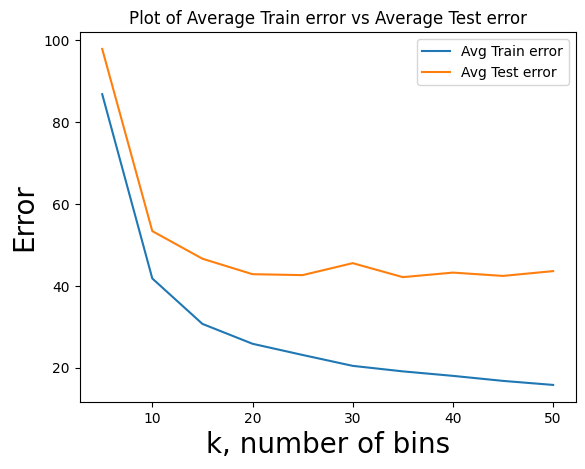

In [6]:
# figsize = figure()
plt.plot(Res_df['k'], Res_df['Avg Train error'],label='Avg Train error')
plt.plot(Res_df['k'], Res_df['Avg Test error'],label='Avg Test error')
plt.xlabel('k, number of bins', fontsize=20); plt.ylabel('Error', fontsize = 20)
plt.title('Plot of Average Train error vs Average Test error')
plt.legend()